In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("src")

from poisson_solver import PoissonSolver
from structure_manager import StructureManager
import visualizer

### Point Charge

In [21]:
nx, ny, nz = 41, 41, 41
h = 0.1e-9
k_center, i_center, j_center = nz // 2, nx // 2, ny // 2

epsilon_0 = 8.854187817e-12  # Vacuum permittivity (F/m)
epsilon_r = 1.0
epsilon = np.ones((nz, nx, ny)) * epsilon_r

Q = -1.602e-19  # C (electron charge, negative)
rho = np.zeros((nz, nx, ny))
rho[k_center, i_center, j_center] = Q / (h**3)  # Charge density (C/m³)

boundary_conditions = {
    "z_top": {'type': 'dirichlet', 'value': 0.0},
    'z_bottom': {'type': 'dirichlet', 'value': 0.0},
    'x_sides': {'type': 'dirichlet', 'value': 0.0},
    'y_sides': {'type': 'dirichlet', 'value': 0.0},
}

params = {
    "epsilon": epsilon,
    "grid_spacing": h,
    "boundary_conditions": boundary_conditions,
    "electrode_mask": None,
    "electrode_voltages": None,
}

solver = PoissonSolver(
    params=params,
    omega=1.8,
    tolerance=1e-8,
    max_iterations=10000,
)

In [22]:
phi, info = solver.solve(rho=rho)

Iteration 10: Max Δφ = 1.794881e+00
Iteration 20: Max Δφ = 2.937230e-01
Iteration 30: Max Δφ = 6.892887e-02
Iteration 40: Max Δφ = 1.858267e-02
Iteration 50: Max Δφ = 5.074271e-03
Iteration 60: Max Δφ = 5.146645e-03
Iteration 70: Max Δφ = 1.344152e-03
Iteration 80: Max Δφ = 7.023274e-04
Iteration 90: Max Δφ = 3.667241e-04
Iteration 100: Max Δφ = 1.914918e-04
Iteration 110: Max Δφ = 9.999072e-05
Iteration 120: Max Δφ = 5.221182e-05
Iteration 130: Max Δφ = 2.726326e-05
Iteration 140: Max Δφ = 1.423596e-05
Iteration 150: Max Δφ = 7.433541e-06
Iteration 160: Max Δφ = 3.881546e-06
Iteration 170: Max Δφ = 2.026813e-06
Iteration 180: Max Δφ = 1.058334e-06
Iteration 190: Max Δφ = 5.526264e-07
Iteration 200: Max Δφ = 2.885629e-07
Iteration 210: Max Δφ = 1.506779e-07
Iteration 220: Max Δφ = 7.867894e-08
Iteration 230: Max Δφ = 4.108350e-08
Iteration 240: Max Δφ = 2.145243e-08
Iteration 250: Max Δφ = 1.120174e-08


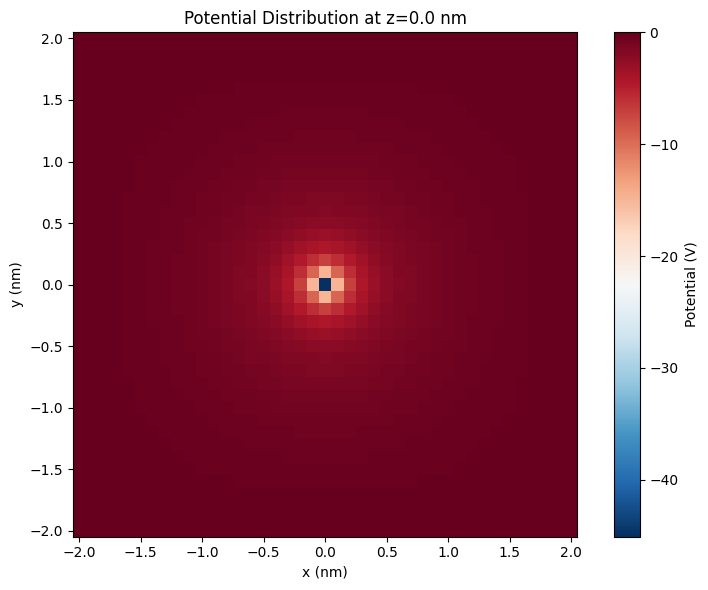

In [25]:
x = np.linspace(-20, 20, nx) * h  # nm
y = np.linspace(-20, 20, ny) * h  # nm
z = np.linspace(-20, 20, nz) * h  # nm

visualizer.plot_potential_slice(
    phi,
    x,
    y,
    z,
    z_index=k_center,
    )

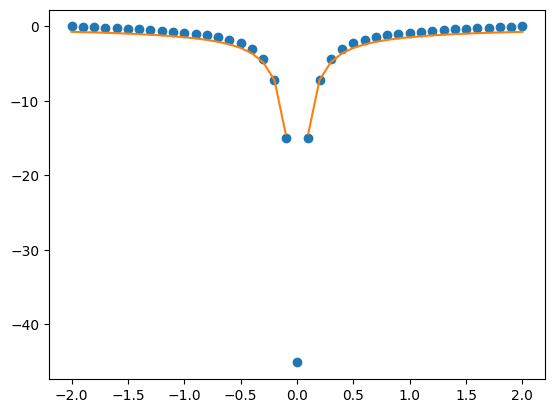

In [26]:
def phi_analytical(r):
    if r == 0:
        return np.nan  # Avoid division by zero at the origin
    return Q / (4 * np.pi * epsilon_0 * epsilon_r * np.abs(r))


plt.figure()
plt.plot(
    x * 1e9,
    phi[k_center, i_center, :],
    label='Numerical',
    marker='o',
    linestyle='None',
)

plt.plot(
    x * 1e9,
    [phi_analytical(r) for r in x],
    label='Analytical',
    linestyle='-',
)

In [27]:
phi[k_center+4, i_center, j_center] / phi[k_center+8, i_center, j_center]

np.float64(2.5868490221729137)

### StructureManager

In [2]:
config_path = "configs/example.yaml"

manager = StructureManager(config_path)

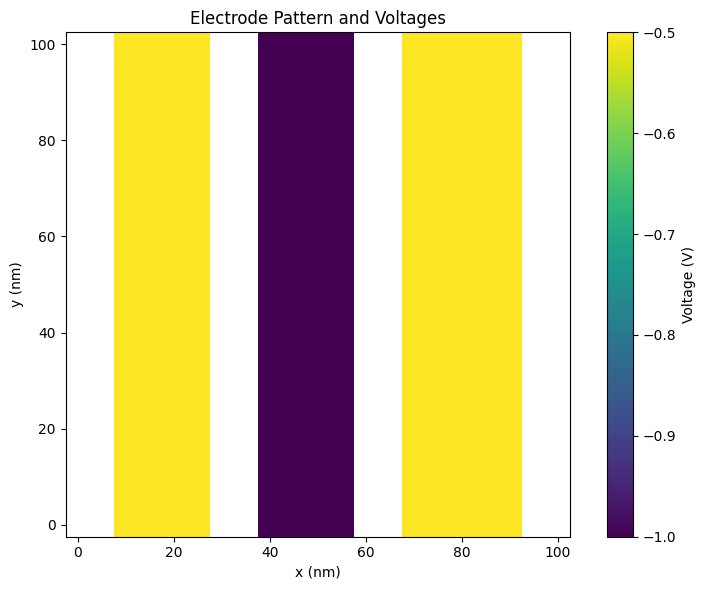

In [7]:
x = np.linspace(0, manager.size_x, manager.nx)
y = np.linspace(0, manager.size_y, manager.ny)

visualizer.plot_electrode_pattern(
    manager.electrode_mask,
    manager.electrode_voltages,
    x, y, z_index=1,
)

### Convergence test

In [2]:
nx, ny, nz = 21, 21, 21
h = 1e-9

epsilon_0 = 8.854e-12  # Vacuum permittivity
epsilon = np.ones((nz, nx, ny)) * 11.7  # Si

electrode_mask = np.zeros((nz, nx, ny), dtype=bool)
electrode_thickness = 2  # Thickness of electrode in z
ew = 2  # Electrode width in x and y
exmin, exmax = nx // 2 - ew // 2, nx // 2 + ew // 2  # position of electrode in x
eymin, eymax = ny // 2 - ew // 2, ny // 2 + ew // 2  # position of electrode in y
electrode_mask[:electrode_thickness, exmin:exmax+1, eymin:eymax+1] = True

electrode_voltages = np.zeros((nz, nx, ny))
electrode_voltage = -0.5
electrode_voltages[electrode_mask] = electrode_voltage

boundary_conditions = {
    'z_top': {'type': 'neumann', 'value': 0.0},
    'z_bottom': {'type': 'dirichlet', 'value': 0.0},
    'x_sides': {'type': 'dirichlet', 'value': 0.0},
    'y_sides': {'type': 'dirichlet', 'value': 0.0},
}

params = {
    'epsilon': epsilon,
    'grid_spacing': h,
    'boundary_conditions': boundary_conditions,
    'electrode_mask': electrode_mask,
    'electrode_voltages': electrode_voltages,
}

solver = PoissonSolver(
    params=params,
    omega=1.8,
    tolerance=1e-6,
    max_iterations=1000,
)

In [3]:
# phi, info = solver.solve()
# x = np.linspace((nx-1) // 2 * h, (nx-1) // 2 * h, nx)
# y = np.linspace((ny-1) // 2 * h, (ny-1) // 2 * h, ny)
# z = np.linspace(-(nz - 1) * h, 0, nz)
# X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
# phi_initial = epsilon_0 * electrode_voltage / (h * (k_electrode_bottom)) * Z
phi_initial = np.zeros((nx, ny, nz))
phi_initial[electrode_mask] = electrode_voltage
phi, info = solver.solve(phi_initial=phi_initial)

Iteration 10: Max Δφ = 7.217958e-03
Iteration 20: Max Δφ = 5.113390e-04
Iteration 30: Max Δφ = 5.087380e-05
Iteration 40: Max Δφ = 9.987627e-06
Iteration 50: Max Δφ = 5.207088e-06


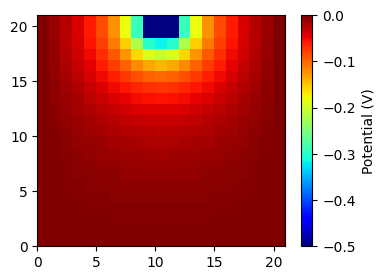

In [4]:
plt.figure(figsize=(4, 3))
plt.pcolor(phi[::-1, :, ny//2], cmap='jet')
plt.colorbar(label='Potential (V)')

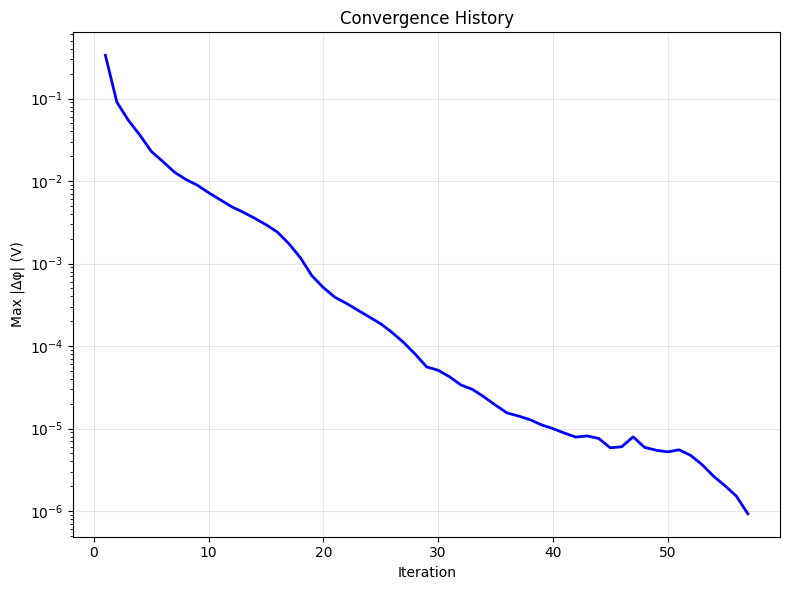

In [5]:
visualizer.plot_convergence(
    convergence_history=solver.convergence_history,)

In [71]:
rho = np.zeros((nx, ny, nz))
phi2 = solver._sor_iteration(phi, rho)

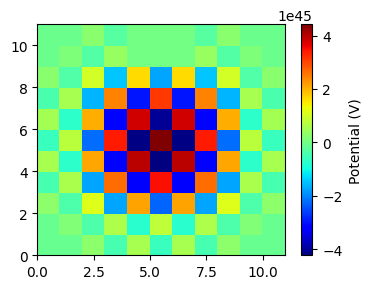

In [72]:
plt.figure(figsize=(4, 3))
plt.pcolor(phi2[:, ny//2, :].T, cmap='jet')
plt.colorbar(label='Potential (V)')

# 平行平板コンデンサ

In [2]:
nx, ny, nz = 3, 3, 11
h = 2e-9

epsilon = np.ones((nx, ny, nz)) * 3.9  # SiO2

boundary_conditions = {
    'z_top': {'type': 'dirichlet', 'value': 1.0},  # 1V
    'z_bottom': {'type': 'dirichlet', 'value': 0.0},  # 0V
    'x_sides': {'type': 'neumann', 'value': 0.0},
    'y_sides': {'type': 'neumann', 'value': 0.0},
}

solver = PoissonSolver(
    epsilon=epsilon,
    grid_spacing=h,
    boundary_conditions=boundary_conditions,
    omega=1.5,
    tolerance=1e-8,
    max_iterations=5000,
)

In [3]:
phi, info = solver.solve()

Iteration 10: Residual = 5.846971e-02
Iteration 20: Residual = 3.581534e-02
Iteration 30: Residual = 2.625501e-02
Iteration 40: Residual = 2.019244e-02
Iteration 50: Residual = 1.570892e-02
Iteration 60: Residual = 1.225254e-02
Iteration 70: Residual = 9.562118e-03
Iteration 80: Residual = 7.463406e-03
Iteration 90: Residual = 5.825487e-03
Iteration 100: Residual = 4.547053e-03
Iteration 110: Residual = 3.549183e-03
Iteration 120: Residual = 2.770300e-03
Iteration 130: Residual = 2.162347e-03
Iteration 140: Residual = 1.687812e-03
Iteration 150: Residual = 1.317415e-03
Iteration 160: Residual = 1.028303e-03
Iteration 170: Residual = 8.026377e-04
Iteration 180: Residual = 6.264957e-04
Iteration 190: Residual = 4.890088e-04
Iteration 200: Residual = 3.816939e-04
Iteration 210: Residual = 2.979297e-04
Iteration 220: Residual = 2.325478e-04
Iteration 230: Residual = 1.815143e-04
Iteration 240: Residual = 1.416803e-04
Iteration 250: Residual = 1.105880e-04
Iteration 260: Residual = 8.631901

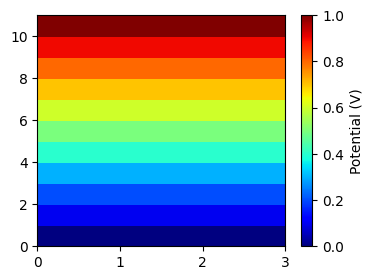

In [4]:
plt.figure(figsize=(4, 3))
plt.pcolor(phi[:, 0, :].T, cmap='jet')
plt.colorbar(label='Potential (V)')